In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


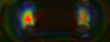

In [ ]:
from PIL import Image
img = Image.open('/content/gdrive/MyDrive/racedata/LiteonRacingData/A/0/20190802023050_8SSB20N60164H1DG97Y02G6_R1248_1_SolderLight.png')
img

In [ ]:
from tensorflow.keras.preprocessing.image import load_img,img_to_array
img = load_img('/content/gdrive/MyDrive/racedata/LiteonRacingData/A/0/20190802023050_8SSB20N60164H1DG97Y02G6_R1248_1_SolderLight.png')
data = img_to_array(img)
data.shape

(42, 110, 3)

In [10]:
# load the Keras libraries.
from keras.layers import Dense, Conv2D, MaxPooling2D , Flatten , Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import densenet
from keras.models import Sequential, Model, load_model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
from keras import regularizers
from keras import backend as K

In [ ]:
K.set_learning_phase(1)

/usr/local/lib/python3.7/dist-packages/keras/backend.py:401: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


In [12]:
img_width, img_height = 224, 224
nb_train_samples = 12000
nb_validation_samples = 200
epochs = 10
batch_size = 32
n_classes = 8

In [13]:
train_data_dir = "/content/gdrive/MyDrive/racedata/LiteonRacingData/A/"
validation_data_dir = "/content/gdrive/MyDrive/racedata/LiteonRacingData/B/"

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    zoom_range=0.2,
    rotation_range = 5,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 12000 images belonging to 8 classes.
Found 200 images belonging to 8 classes.


In [ ]:
BASE_WEIGHTS_PATH = ('https://storage.googleapis.com/tensorflow/'
                     'keras-applications/densenet/')
DENSENET121_WEIGHT_PATH = (
    BASE_WEIGHTS_PATH + 'densenet121_weights_tf_dim_ordering_tf_kernels.h5')

In [ ]:
def build_model():
    base_model = densenet.DenseNet121(input_shape=(img_width, img_height, 3),
                                     #weights='../input/full-keras-pretrained-no-top/densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5',
                                     weights='imagenet', #add
                                     #weights= DENSENET121_WEIGHT_PATH,
                                     include_top=False,
                                     pooling='avg')
    for layer in base_model.layers:
      layer.trainable = True

    x = base_model.output
    x = Dense(1000, kernel_regularizer=regularizers.l1_l2(0.01), activity_regularizer=regularizers.l2(0.01))(x)
    x = Activation('relu')(x)
    x = Dense(500, kernel_regularizer=regularizers.l1_l2(0.01), activity_regularizer=regularizers.l2(0.01))(x)
    x = Activation('relu')(x)
    predictions = Dense(n_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    
    return model

In [ ]:
model = build_model()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc', 'mse'])

29097984/29084464 [==============================] - 0s 0us/step


In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=8, verbose=1, min_delta=1e-4)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=1, min_delta=1e-4)
callbacks_list = [early_stop, reduce_lr]

In [ ]:
model_history = model.fit_generator(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    callbacks=callbacks_list)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
375/375 [==============================] - 3925s 10s/step - loss: 30.0872 - acc: 0.8657 - mse: 0.0262 - val_loss: 3.2112 - val_acc: 0.6927 - val_mse: 0.0578
Epoch 2/50
375/375 [==============================] - 187s 499ms/step - loss: 2.2777 - acc: 0.9080 - mse: 0.0164 - val_loss: 3.8745 - val_acc: 0.2552 - val_mse: 0.1053
Epoch 3/50
375/375 [==============================] - 186s 497ms/step - loss: 2.1716 - acc: 0.9291 - mse: 0.0140 - val_loss: 4.5122 - val_acc: 0.1146 - val_mse: 0.1298
Epoch 4/50
375/375 [==============================] - 187s 498ms/step - loss: 2.1408 - acc: 0.9335 - mse: 0.0136 - val_loss: 3.3988 - val_acc: 0.3021 - val_mse: 0.0913
Epoch 5/50
375/375 [==============================] - 187s 499ms/step - loss: 2.0782 - acc: 0.9430 - mse: 0.0115 - val_loss: 3.4562 - val_acc: 0.3229 - val_mse: 0.0959

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 6/50
375/375 [==============================] - 187s 497ms/step - loss: 

In [ ]:
#model.save('Densenetmodel.h5')
model.save('/content/gdrive/MyDrive/racedata/DenseNetmodel.h5')

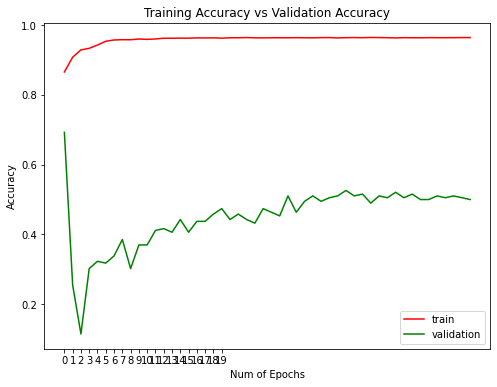

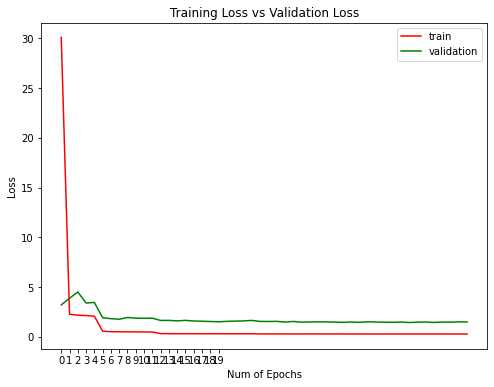

In [ ]:
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd 
plt.figure(0)
plt.plot(model_history.history['acc'],'r')
plt.plot(model_history.history['val_acc'],'g')
plt.xticks(np.arange(0, 20, 1.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Validation Accuracy")
plt.legend(['train','validation'])

plt.figure(1)
plt.plot(model_history.history['loss'],'r')
plt.plot(model_history.history['val_loss'],'g')
plt.xticks(np.arange(0, 20, 1.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])

plt.show()

In [ ]:
model.evaluate_generator(validation_generator, steps=None, max_queue_size=10, workers=1, use_multiprocessing=False)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[1.490088701248169, 0.5049999952316284, 0.0781884491443634]

In [ ]:
pred = model.predict_generator(validation_generator, steps=None, max_queue_size=10, workers=1, use_multiprocessing=False, verbose=1)
predicted = np.argmax(pred, axis=1)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


7/7 [==============================] - 2s 88ms/step


In [7]:
import tensorflow as tf
model = tf.keras.models.load_model('/content/gdrive/MyDrive/racedata/DenseNetmodel.h5')

0
1
2
3
4
5
6
7
Accuracy Score: 0.31


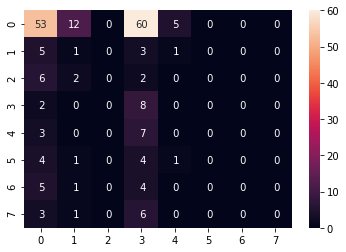

In [25]:
import numpy as np
import seaborn as sns
pred = model.predict(validation_generator)
pred=np.argmax(pred,axis=1)
pred_df=df2.copy()
labels={}
for l,v in validation_generator.class_indices.items():
    print(l)
    labels.update({v:l})
pred_df['pred']=pred
pred_df['pred']=pred_df['pred'].apply(lambda x: labels[x])
    
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
print(f"Accuracy Score: {accuracy_score(pred_df['label'],pred_df['pred'])}")
sns.heatmap(confusion_matrix(pred_df['label'],pred_df['pred']), annot=True, fmt='2d')

In [21]:
import os
import pandas as pd
dir = "/content/gdrive/MyDrive/racedata/LiteonRacingData/B/"
label = []
path = []
for dirname, _,filenames in os.walk(dir):
    for filename in filenames:
        #print(filename)
        if os.path.splitext(filename)[1]=='.png':
            if dirname.split()[-1]!='GT':
                #print(os.path.split(dirname))
                label.append(os.path.split(dirname)[1][0])
                path.append(os.path.join(dirname,filename))
                print(os.path.join(dirname,filename))
df2 = pd.DataFrame(columns = ['path','label'])
df2['path'] = path
df2['label'] = label

/content/gdrive/MyDrive/racedata/LiteonRacingData/B/1/20190816145757_R116.png
/content/gdrive/MyDrive/racedata/LiteonRacingData/B/1/20190816145757_R2362.png
/content/gdrive/MyDrive/racedata/LiteonRacingData/B/1/20190816170639_R59.png
/content/gdrive/MyDrive/racedata/LiteonRacingData/B/1/20200316094821_200265880400533_OR7_1_view69.png
/content/gdrive/MyDrive/racedata/LiteonRacingData/B/1/20200316100022_200265880400788_XR20_1_view20.png
/content/gdrive/MyDrive/racedata/LiteonRacingData/B/1/20200322181650_A6521L3K01269_R43_1_view9.png
/content/gdrive/MyDrive/racedata/LiteonRacingData/B/1/20200224193213_R1031_1.png
/content/gdrive/MyDrive/racedata/LiteonRacingData/B/1/20200228092633_OR8081_1.png
/content/gdrive/MyDrive/racedata/LiteonRacingData/B/1/20200314202325_200366067100021_PR1077_1_view65.png
/content/gdrive/MyDrive/racedata/LiteonRacingData/B/1/20200314194603_200366067100405_O2R58_1_view50.png
/content/gdrive/MyDrive/racedata/LiteonRacingData/B/5/20191115142401_8SSB20N60289H1DG9BC07

In [22]:
df2 = df2.sample(frac = 1)
df2 = df2.groupby(['label']).head(1000)

In [23]:
df2['label'] = df2['label'].astype('category')
df2['label'].value_counts()

0    130
7     10
6     10
5     10
4     10
3     10
2     10
1     10
Name: label, dtype: int64